### Sundqvist Scheme

How about we fit the Sundqvist model where we fit the tuning parameters to the data? <br>
We let the parameters depend on whether they are taken over land or over the sea.

In this version, we find the optimal set of hyperparameters automatically!

In [3]:
# 1000 samples, grid_spacing of 0.2: 12 seconds
# 1000 samples, grid_spacing of 0.1: 130 seconds

# 100.000 samples, grid_spacing of 0.2: 850 seconds
# 100.000 samples, grid_spacing of 0.1: Should take 2-3 hours

In [4]:
import os
import sys
import time
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import LambdaCallback

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression/')
from functions import evaluate_sundqvist

# Added to the PDF name
ran = np.random.randint(10**3)
print(ran)

seed = 7
np.random.seed(seed)

150


In [5]:
# Load columns of data
folder_data = '/home/b/b309170/workspace_icon-ml/symbolic_regression/data/'

input_train = np.load(os.path.join(folder_data, 'input_train_with_deriv.npy'))
input_valid = np.load(os.path.join(folder_data, 'input_valid_with_deriv.npy'))
output_train = np.load(os.path.join(folder_data, 'output_train_with_deriv.npy'))
output_valid = np.load(os.path.join(folder_data, 'output_valid_with_deriv.npy'))

In [6]:
# Features
new_features = ['qv', 'qv_z', 'qv_zz', 'qc', 'qc_z', 'qc_zz', 'qi', 'qi_z', 'qi_zz', 'temp', 'temp_z', 'temp_zz', \
                'pres', 'pres_z', 'pres_zz', 'zg', 'fr_land']

# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 17)

In [7]:
# Add relative humidity
pres_train = input_train[:, :, loc['pres']]
qv = input_train[:, :, loc['qv']]
temp = input_train[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

new_features.append('rh')
input_train = np.append(input_train, np.expand_dims(r, -1), axis=2)

# The same for input_valid
pres_valid = input_valid[:, :, loc['pres']]
qv = input_valid[:, :, loc['qv']]
temp = input_valid[:, :, loc['temp']]

T0 = 273.15
r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=2)

In [8]:
# Add surface pressure to every sample
ps_train = np.expand_dims(np.repeat(np.expand_dims(pres_train[:, -1], -1), 27, axis=1), -1)
ps_valid = np.expand_dims(np.repeat(np.expand_dims(pres_valid[:, -1], -1), 27, axis=1), -1)

new_features.append('ps')
input_train = np.append(input_train, ps_train, axis=2)
input_valid = np.append(input_valid, ps_valid, axis=2)

In [9]:
# Updating loc
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i
    
input_train.shape

(100000, 27, 19)

In [10]:
# Flatten before passing it to LinearRegression()
flattened_input_train = np.reshape(input_train, (-1, len(new_features)))
flattened_input_valid = np.reshape(input_valid, (-1, len(new_features)))
flattened_output_train = np.reshape(output_train, -1)
flattened_output_valid = np.reshape(output_valid, -1)

flattened_input_train.shape

(2700000, 19)

In [11]:
# We split the training data into cells over land vs sea
land_ind = np.where(flattened_input_train[:, loc['fr_land']] > 0.5)[0]
sea_ind = np.where(flattened_input_train[:, loc['fr_land']] <= 0.5)[0]

input_land = flattened_input_train[land_ind]
output_land = flattened_output_train[land_ind]
input_sea = flattened_input_train[sea_ind]
output_sea = flattened_output_train[sea_ind]

In [12]:
len(land_ind)/flattened_input_train.shape[0]

0.26025

### Fitting hyperparameters
Original ones: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$

### Create custom layer

In [ ]:
class Sundq_Layer(tf.keras.layers.Layer):

    # These are the output units
    def __init__(self, units=1):
        super(Sundq_Layer, self).__init__()
        self.units = units

    def build(self, input_shape):  # Create the state of the layer (weights)
        
        # Initializing with the original values
        # rsat must always be greater than r0_top and r0_surf! How could we enforce this? (*)
        rsat_init = tf.constant_initializer(1)
        r0_top_init = tf.constant_initializer(0.8)
        r0_surf_init = tf.constant_initializer(0.968)
        n_init = tf.constant_initializer(2)  
    
        self.rsat = tf.Variable(name='rsat', initial_value=rsat_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_top = tf.Variable(name='r0_top', initial_value=r0_top_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.r0_surf = tf.Variable(name='r0_surf', initial_value=r0_surf_init(shape=(1, self.units), dtype='float32'), trainable=True)
        self.n = tf.Variable(name='n', initial_value=n_init(shape=(1, self.units), dtype='float32'), trainable=True)

    def call(self, inputs):  # Defines the computation from inputs to outputs
        ps = inputs[:, 0]
        p = inputs[:, 1]
        rh = inputs[:, 2]
        
        r0 = self.r0_top + (self.r0_surf - self.r0_top)*tf.exp(1-(ps/p)**self.n)
        
        # div < 0, only if rsat < r0. But this goes against (*)
        div = (tf.minimum(rh, self.rsat) - self.rsat)/(r0 - self.rsat)
        
        # tf.sqrt is tricky, because its gradient in 0 is infinite!
        c = 1 - tf.sqrt(tf.maximum(div, 1e-9)) # in [0,1]
        
        # If rh > r0 we return c, otherwise we set it to 0
        c_out = tf.maximum(tf.sign(rh - r0), 0)*c
        
        return 100*tf.transpose(c)

**Land**

In [ ]:
# Best parameters from the hyperparameter search
epochs_opt = 10
batchsize_opt = 32
optimizer_opt = tf.keras.optimizers.Adagrad
lr_opt = 0.0523026

In [ ]:
sundq_layer = Sundq_Layer()
model = tf.keras.models.Sequential(sundq_layer)
model.compile(optimizer=optimizer_opt(learning_rate=lr_opt), loss='mse')

In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

history = model.fit(input_land[:, [loc['ps'], loc['pres'], loc['rh']]], output_land, epochs=epochs_opt, batch_size=batchsize_opt, \
                   callbacks = [print_weights])

In [ ]:
model.weights

**Sea**

In [ ]:
sundq_layer = Sundq_Layer()
model = tf.keras.models.Sequential(sundq_layer)
model.compile(optimizer=optimizer_opt(learning_rate=lr_opt), loss='mse')

In [ ]:
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(model.layers[0].get_weights()))

history = model.fit(input_sea[:, [loc['ps'], loc['pres'], loc['rh']]], output_sea, epochs=epochs_opt, batch_size=batchsize_opt, \
                   callbacks = [print_weights])

In [ ]:
model.weights

### Performance with the best hyperparameter setting (To run)

Originally: $r_{sat} = 1, r_{0, top} = 0.8, r_{0, surf} = 0.968, n = 2$ <br> 
Manually tuned over land:
$r_{sat} = 1.10, r_{0, top} = 0.2, r_{0, surf} = 0.85, n = 1.62$ <br> 
Manually tuned over sea:
$r_{sat} = 1, r_{0, top} = 0.34, r_{0, surf} = 0.95, n = 1.35$ <br> 
Automatically tuned over land:
$r_{sat} = 1.48, r_{0, top} = 0, r_{0, surf} = 0.49, n = 1.11$ <br> 
Automatically tuned over sea:
$r_{sat} = 1.43, r_{0, top} = 0.04, r_{0, surf} = 0.77, n = 1.28$

In [13]:
# Differentiate between original, manually and automatically tuned!
mse_train, r2_train = evaluate_sundqvist(flattened_input_train, flattened_output_train, loc, tuned='automatically')
mse_train_land, r2_train_land = evaluate_sundqvist(input_land, output_land, loc, tuned='automatically')
mse_train_sea, r2_train_sea = evaluate_sundqvist(input_sea, output_sea, loc, tuned='automatically')
mse_valid, r2_valid = evaluate_sundqvist(flattened_input_valid, flattened_output_valid, loc, tuned='automatically')

In [14]:
# Write results to JSON

results = {}
results['Training MSE'] = mse_train
results['Training R2'] = r2_train
results['Land MSE'] = mse_train_land
results['Land R2'] = r2_train_land
results['Sea MSE'] = mse_train_sea
results['Sea R2'] = r2_train_sea
results['Validation MSE'] = mse_valid
results['Validation R2'] = r2_valid

with open('/home/b/b309170/workspace_icon-ml/symbolic_regression/baselines/sundqvist_results/results.json', 'w') as file:
    json.dump(results, file)

**Extra plot**

Text(0.5, 1.0, 'Cloud Cover distributions')

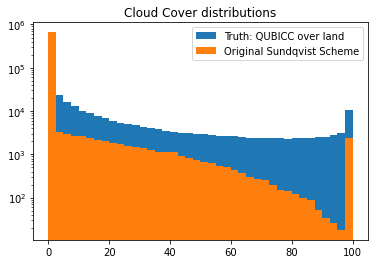

In [530]:
plt.hist(output_land, bins=40, log=True)
plt.hist(predictions, bins=40, log = True)
plt.legend(['Truth: QUBICC over land', 'Original Sundqvist Scheme'])
plt.title('Cloud Cover distributions')